In [49]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import warnings                               
warnings.filterwarnings('ignore')

# 1. Plotting Waves

In [2]:
#read each csv file in current_directory and store it in dataframes

current_directory = os.getcwd()
csv_files = glob.glob(os.path.join(current_directory, 'ABR_exported_files/*.csv'))

dataframes = {}
for file in csv_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    if pd.read_csv(file).shape[1] > 1:
        dataframes[filename] = pd.read_csv(file)
    else:
        dataframes[filename] = pd.read_csv(file, skiprows=2)
we_have_gt = {key: dataframes[key] for key in dataframes.keys() & {'B1_1282_baseline', 'B2_1283_baseline', 'B2_1288_baseline'}}
len(we_have_gt)

3

In [8]:
gt_data = {
    'B2_1283_baseline': {
        4000: {
            90: 0.0189,
            70: 0.00494
        },
        8000: {
            90: 0.01488,
            70: 0.01046
        },
        16000: {
            90: 0.02141,
            70: 0.01074
        },
        24000: {
            90: 0.02374,
            70: 0.01365
        },
        32000: {
            90: 0.02074,
            70: 0.01269
        }
    },
    'B2_1288_baseline': {
        4000: {
            90: 0.01338,
            70: 0.00057
        },
        8000: {
            90: 0.01093,
            70: 0.0014
        },
        16000: {
            90: 0.01667,
            70: 0.01044
        },
        24000: {
            90: 0.01504,
            70: 0.00747
        },
        32000: {
            90: 0.01421,
            70: 0.00444
        }
    },
    'B1_1282_baseline': {
        4000: {
            90: 0.02278,
            70: 0.0029
        },
        8000: {
            90: 0.02173,
            70: 0.0059
        },
        16000: {
            90: 0.03456,
            70: 0.02531
        },
        24000: {
            90: 0.03234,
            70: 0.01168
        },
        32000: {
            90: 0.02777,
            70: 0.00671
        }
    }
}

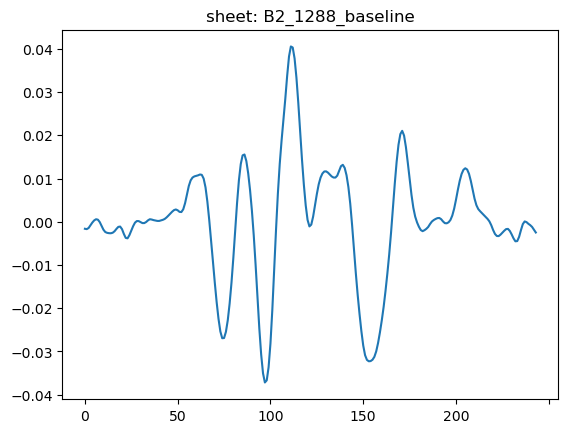

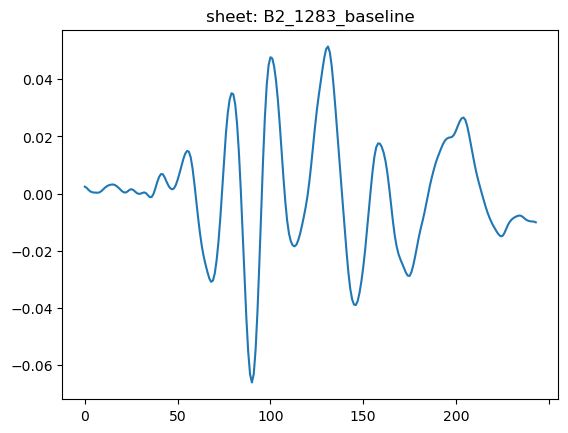

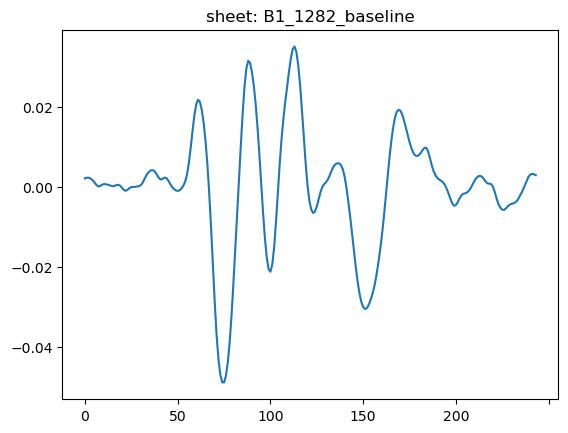

In [3]:
for filename, df in we_have_gt.items():
    khz = df[df['Freq(Hz)'] == 8000]
    dbkhz = khz[khz['Level(dB)'] == 90]
    index = dbkhz.index.values[0]
    final = df.iloc[index,48:]
    final = pd.to_numeric(final, errors='coerce')
    
    plt.figure()  
    final.plot()
    plt.title(f'sheet: {filename}') 
    plt.show()
    

# 2. Identifying Peaks

In [95]:
def plotting_waves(dataframes=we_have_gt, freq=16000, db=90, n=25):
    for filename, df in dataframes.items():
        khz = df[df['Freq(Hz)'] == freq]
        dbkhz = khz[khz['Level(dB)'] == db]
        index = dbkhz.index.values[0]
        final = df.iloc[index, 48:]
        final = pd.to_numeric(final, errors='coerce')

        # Find highest peaks separated by at least n data points
        peaks, _ = find_peaks(final, distance=n)
        highest_peaks = peaks[np.argsort(final[peaks])[-5:]]

        loss_value = None
        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_value = final[np.sort(highest_peaks)[0]]
            if gt_data.get(filename, {}).get(freq, {}).get(db) is not None:
                loss_value = (gt_data[filename][freq][db] - first_peak_value)**2

        plt.figure()
        plt.plot(final)
        
        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak = np.sort(highest_peaks)[0]
            plt.plot([first_peak, first_peak], [final[first_peak], gt_data.get(filename, {}).get(freq, {}).get(db, np.nan)], "--", color='gray')
            plt.plot(first_peak, gt_data.get(filename, {}).get(freq, {}).get(db, np.nan), "o", color='blue', alpha = 0.5)

        x_ticks = np.arange(0, len(final), 20)
        plt.xticks(x_ticks)

        title = f'sheet: {filename}'
        if loss_value is not None:
            title += f', loss value = {loss_value}'

        plt.title(title)
        plt.plot(highest_peaks, final[highest_peaks], "x")
        print(loss_value)

        plt.show()

4.000000000001062e-12


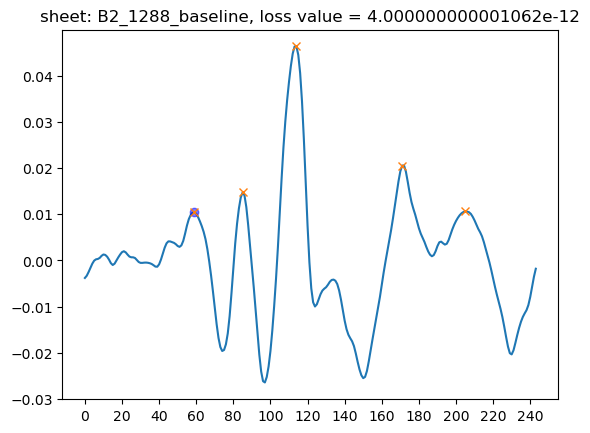

4.000000000001062e-12


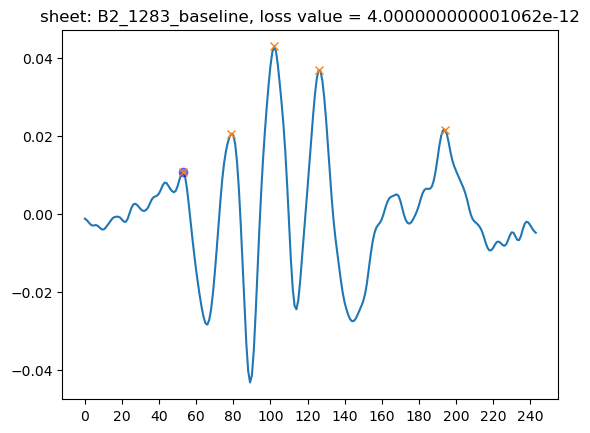

0.000375274384


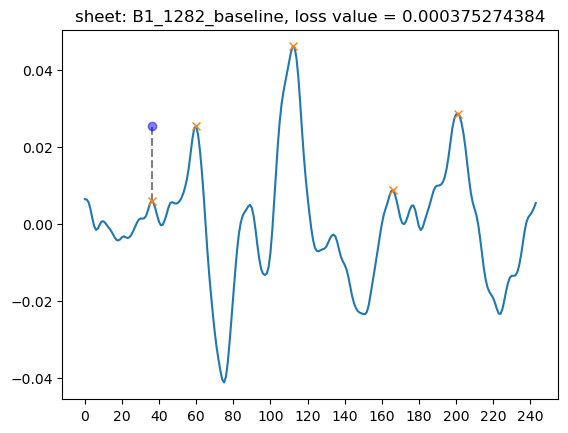

In [127]:
plotting_waves(freq=16000, db=70, n=5)

In [132]:
from sklearn.model_selection import KFold

def cross_validate(dataframes=we_have_gt, freq=16000, db=90, n_values=[20, 30, 40, 50], num_folds=3):
    overall_loss = {}

    for n in n_values:
        losses = []

        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(dataframes):
            train_data = {key: dataframes[key] for i, key in enumerate(dataframes) if i in train_index}
            test_data = {key: dataframes[key] for i, key in enumerate(dataframes) if i in test_index}

            for filename, df in test_data.items():
                khz = df[df['Freq(Hz)'] == freq]
                dbkhz = khz[khz['Level(dB)'] == db]
                index = dbkhz.index.values[0]
                final = df.iloc[index, 48:]
                final = pd.to_numeric(final, errors='coerce')

                # Find highest peaks separated by at least n data points
                peaks, _ = find_peaks(final, distance=n)
                highest_peaks = peaks[np.argsort(final[peaks])[-5:]]

                loss_value = None
                if gt_data.get(filename, {}).get(freq, {}).get(db) is not None and len(highest_peaks) > 0:
                    loss_value = (gt_data[filename][freq][db] - final[np.sort(highest_peaks)][0])**2
                    losses.append(loss_value)

        overall_loss[n] = np.mean(losses)

    best_n = min(overall_loss, key=overall_loss.get)

    return overall_loss, best_n

n_values = range(1,71)
overall_losses, best_n = cross_validate(n_values=n_values, num_folds=3, freq=24000, db=70)
print(f"Overall Losses: {overall_losses}")
print(f"Best n value: {best_n}")

Overall Losses: {1: 1.5219019666666668e-05, 2: 1.5219019666666668e-05, 3: 1.5219019666666668e-05, 4: 1.5219019666666668e-05, 5: 1.5219019666666668e-05, 6: 1.5219019666666668e-05, 7: 1.5219019666666668e-05, 8: 1.5219019666666668e-05, 9: 1.5219019666666668e-05, 10: 1.5219019666666668e-05, 11: 1.5219019666666668e-05, 12: 1.5219019666666668e-05, 13: 1.5219019666666668e-05, 14: 1.5219019666666668e-05, 15: 1.5219019666666668e-05, 16: 1.5219019666666668e-05, 17: 1.5219019666666668e-05, 18: 1.5219019666666668e-05, 19: 1.5219019666666668e-05, 20: 1.5219019666666668e-05, 21: 1.5219019666666668e-05, 22: 1.5219019666666668e-05, 23: 3.692193966666666e-05, 24: 3.692193966666666e-05, 25: 3.7078218e-05, 26: 1.5219019666666668e-05, 27: 9.542913333333332e-07, 28: 9.542913333333332e-07, 29: 3.7593753666666663e-05, 30: 3.7593753666666663e-05, 31: 3.7593753666666663e-05, 32: 3.7593753666666663e-05, 33: 3.7593753666666663e-05, 34: 5.0683825999999995e-05, 35: 9.618477266666666e-05, 36: 9.618477266666666e-05,

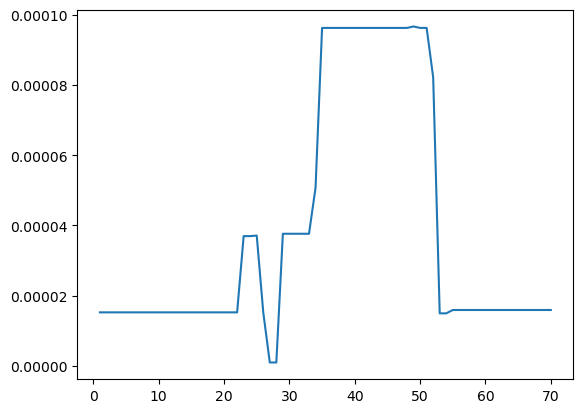

In [133]:
plt.figure()
plt.plot(overall_losses.keys(), overall_losses.values())

In [45]:
data = pd.read_csv('ABR_exported_files/A1_1293_24h PSI.csv', skiprows=2)
khz = data[data['Freq(Hz)'] == 16000]
dbkhz = khz[khz['Level(dB)'] == 90]
index = dbkhz.index.values[0]
final = data.iloc[index,48:]
final = pd.to_numeric(final, errors='coerce')

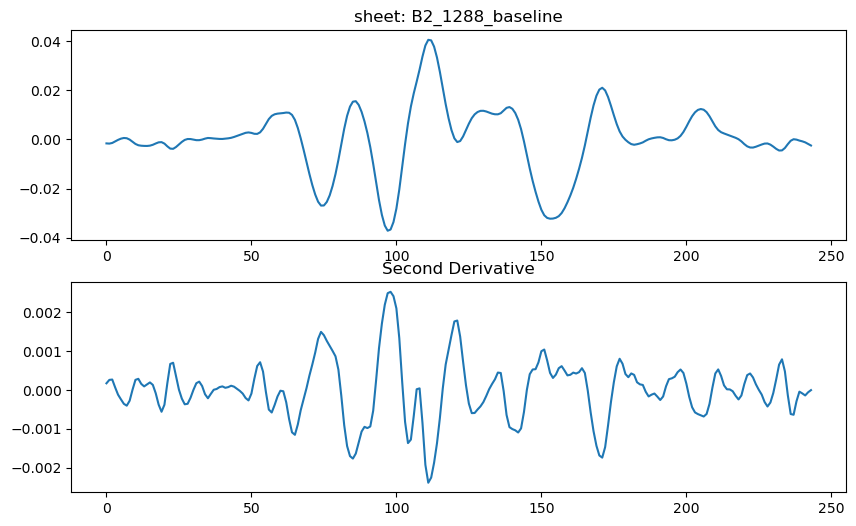

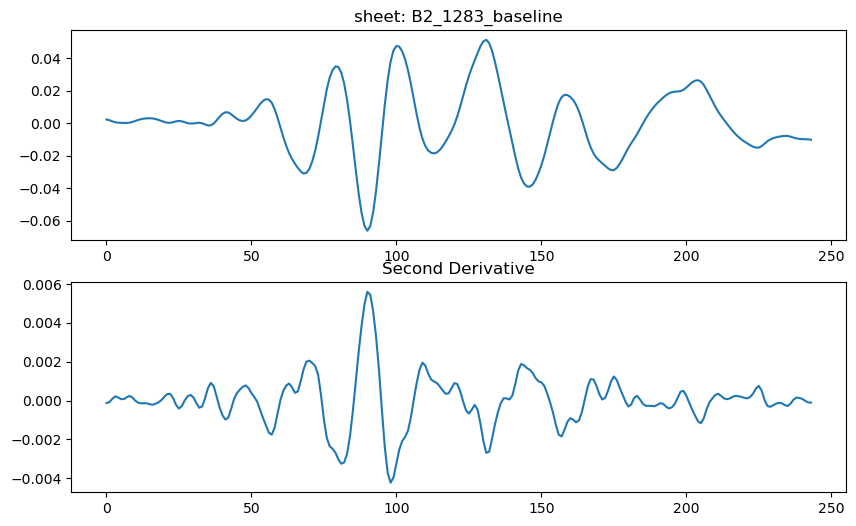

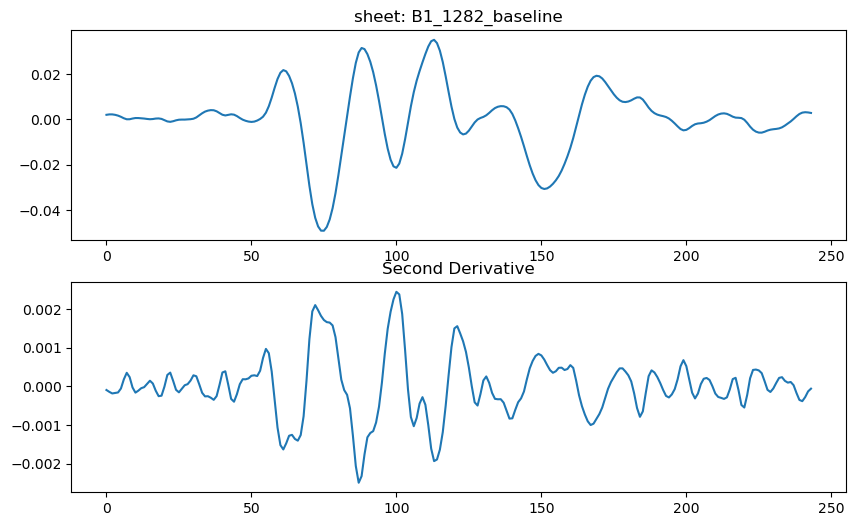

In [7]:
for filename, df in we_have_gt.items():
    khz = df[df['Freq(Hz)'] == 8000]
    dbkhz = khz[khz['Level(dB)'] == 90]
    index = dbkhz.index.values[0]
    final = df.iloc[index,48:]
    final = pd.to_numeric(final, errors='coerce')
    x = final.index.values[:-1].astype(int)
    dy_dx = np.gradient(final[:-1], final.index.values[:-1].astype(int))

    # Calculate the second derivative
    d2y_dx2 = np.gradient(dy_dx, final.index.values[:-1].astype(int))

    # Plot the original data and the second derivative
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(x, final[:-1], label='Original Data')
    plt.title(f'sheet: {filename}')

    #plt.subplot(2, 1, 2)
    #plt.plot(x, dy_dx, label='First Derivative')
    #plt.title('First Derivative')

    plt.subplot(2, 1, 2)
    plt.plot(x, d2y_dx2, label='Second Derivative')
    plt.title('Second Derivative')